# Setup packages and data

In [93]:
### PACKAGES
from keras import layers
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### GET DATA
# path = "/kaggle/input/utkface-new/UTKFace/"
path = "/kaggle/input/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])
image = cv2.imread(path + files[0])
print(image.shape)
    
def get_data(files, image_size):
    ### Convert to RGB, and get age + gender from filename
    images = []
    ages = []
    genders = []
    ethnicity = []
    for file in files:
        image = cv2.imread(path+file)
        image = cv2.resize(image, dsize=image_size)

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        images.append(image_rgb)
        split_var = file.split('_')
        ages.append(split_var[0])
        genders.append(int(split_var[1]))
        #ethnicity.append(int(split_var[2]))
        
    return images, ages, genders, ethnicity

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg
(200, 200, 3)


Format of the file: age_gender_ethnicity_datetime 

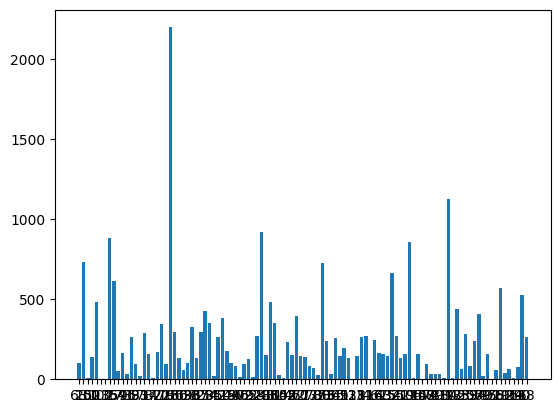

Max value: 99


In [11]:
images, ages, genders, ethnicity = get_data(files=files, image_size=(64,64))
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

# Age and Gender Classifier

Gender: 0 Age: 54


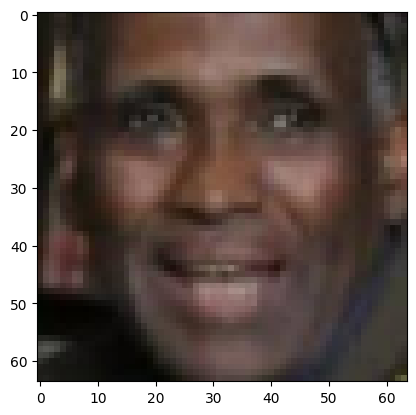

In [12]:
def display(img):
    plt.imshow(img[:,:])
    #plt.set_cmap()
    plt.show()

idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

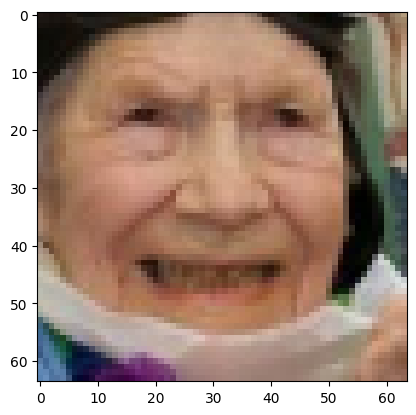

In [24]:
# pre processing
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],sample.shape[2]),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [26]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [20]:
inputs = Input(shape=(64,64,3))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu', name='age_out')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid', name='gender_out')(gender_model)

In [21]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 60, 60,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0],    │
│                     │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        528 │ dropout_2[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │        136 │ dropout_2[3][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,537,410 (24.94 MB)

 Trainable params: 6,537,410 (24.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],
              validation_data=(x_test,[y_test[:,0],y_test[:,1]]),
              epochs = 25, 
              batch_size=128,
              shuffle = True)

In [ ]:
model.save('data.h5')

In [ ]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
history = h
plt.plot(history.history['dense_30_accuracy'])
plt.plot(history.history['val_dense_30_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
def display(img):
    plt.imshow(img[:,:])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)

NameError: name 'plt' is not defined

# Age Classifier

In [52]:
def get_age_groups(ages: list) -> pd.DataFrame:
    # Convert all values in the ages list to integers
    ages_int = [int(age) for age in ages]

    # Convert the ages to a DataFrame
    ages_df = pd.DataFrame(ages_int, columns=['age'])

    # Define the age bins and labels
    bins = [0, 9, 18, 27, 36, 45, 54, 63, 72, 81]
    labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

    # Create age groups
    ages_df['age_group'] = pd.cut(ages_df['age'], bins=bins, labels=labels, right=False)

    # One-hot encode the age groups
    age_groups = pd.get_dummies(ages_df['age_group'])

    # Example output
    print(f"Age groups:\n{age_groups.head()}")
    
    return age_groups

age_groups = get_age_groups(ages=ages)

Age groups:
    0-10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    81+
0  False  False   True  False  False  False  False  False  False
1  False  False   True  False  False  False  False  False  False
2  False  False   True  False  False  False  False  False  False
3  False  False  False   True  False  False  False  False  False
4  False   True  False  False  False  False  False  False  False


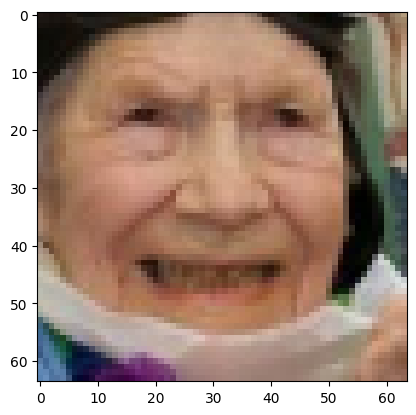

In [54]:
def preprocess_features(size: int, sample, images: list):
    features = np.zeros((size,sample.shape[0],sample.shape[1],sample.shape[2]),dtype = 'float32')
    for i in range(size):
        features[i] = images[i]
    features = features / 255
    display(features[550])
    
    return features

features = preprocess_features(size = size, sample = sample, images = images)

In [55]:
features.shape

(23708, 64, 64, 3)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(features, age_groups, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [ ]:
inputs = Input(shape=(64,64,3))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(9, activation='sigmoid', name='age_out')(age_model)

In [ ]:
model = Model(inputs=inputs, outputs=[age_model])
model.compile(optimizer = 'adam', loss =['categorical_crossentropy'],metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
h = model.fit(x_train,y_train,
              validation_data=(x_test, y_test),
              epochs = 25, 
              batch_size=128,
              shuffle = True)

In [ ]:
model.save('data.h5')

In [ ]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
history = h
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
3plt.show()

# InceptionV3

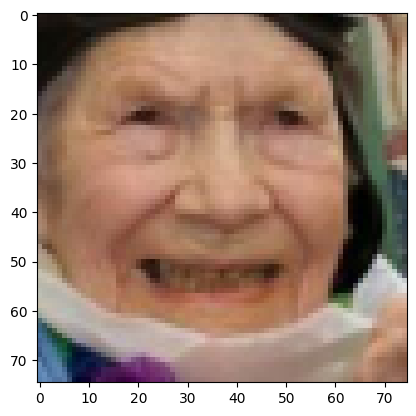

Age groups:
    0-10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    81+
0  False  False   True  False  False  False  False  False  False
1  False  False   True  False  False  False  False  False  False
2  False  False   True  False  False  False  False  False  False
3  False  False  False   True  False  False  False  False  False
4  False   True  False  False  False  False  False  False  False


In [88]:
images, ages, genders, ethnicity = get_data(files=files, image_size=(75,75))
sample = images[500]
features = preprocess_features(size = size, sample = sample, images = images)
age_groups = get_age_groups(ages=ages)
x_train, x_test, y_train, y_test = train_test_split(features, age_groups, test_size=0.2,shuffle  = True)

In [13]:
conv_base = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False
)

conv_base.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [89]:
inputs = keras.Input(shape=(sample.shape[0],sample.shape[1],sample.shape[2]))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(y_train.shape[1], activation="softmax")(x)

inception = keras.Model(inputs=inputs, outputs=outputs)
inception.summary()

inception.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_9 (TrueDivide)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_9 (Subtract)           │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 1, 1, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,119,145 (88.19 MB)

 Trainable params: 1,316,361 (5.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [82]:
x_train.shape

(18966, 80, 80, 3)

In [83]:
x_test.shape

(4742, 80, 80, 3)

In [84]:
y_train.shape

(18966, 9)

In [85]:
y_test.shape

(4742, 9)

In [90]:
inception_history = inception.fit(
    x_train,
    y_train,
    epochs = 10,
    validation_data = (x_test, y_test),
)

Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.2446 - loss: 2.7149 - val_accuracy: 0.2923 - val_loss: 2.8099
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1928 - loss: 22.0366 - val_accuracy: 0.2227 - val_loss: 573.4390
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1595 - loss: 1468.9296 - val_accuracy: 0.2227 - val_loss: 4035.4202
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1599 - loss: 10055.5547 - val_accuracy: 0.0799 - val_loss: 32178.7598
Epoch 5/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1607 - loss: 35051.8633 - val_accuracy: 0.1436 - val_loss: 53280.2109
Epoch 6/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1606 - loss: 74682.5703 - val_accuracy: 0.0407 - val_loss: 124608.6484
Epoch 7/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1569 - loss: 121360.3672 - val_accuracy: 0.2227 - val_loss: 96867.6406
Epoch 8/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19m

### Confusion Matrix

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


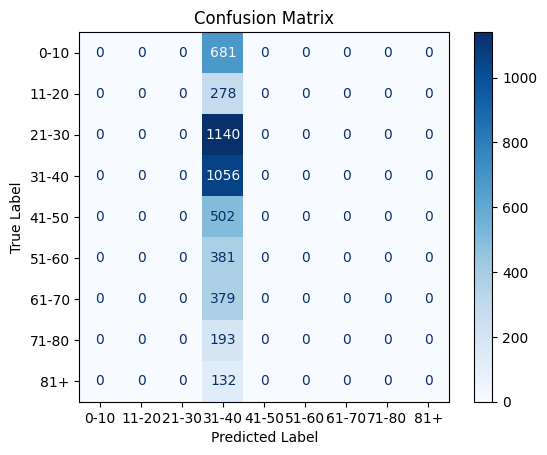

In [95]:
# Get the predicted probabilities
y_pred_probs = inception.predict(x_test)

# Convert the probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it back to class labels
y_true = np.argmax(y_test, axis=1)

# Get confusion matrix
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names
class_names = age_groups.columns

# Plot confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [98]:
pd.Series(y_pred).value_counts()

3    4742
Name: count, dtype: int64